In [1]:
pip install dolphindb

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for dolphindb from https://files.pythonhosted.org/packages/1e/3d/ab1d787aefee3c99151a8b05ead4102885372f794358a0494c60093f8d96/dolphindb-1.30.22.6-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 991.0 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.6 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/1.6 MB 1.1 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.6 MB 1.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.6 MB 1.2 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.6 MB 1.2 MB/s eta 0:00:02
   --------- ------------------------------ 0.4/1.6 MB 1.1 MB/s eta 0:00:02
   ---------- ----------------------------- 0.4/1.6 MB 1.2 MB/s eta 0:00:01
   ------------ -----------

In [87]:
# 导入DolphinDB的Python API
from dolphindb import Session

# 创建DolphinDB会话
session = Session()

# 连接到DolphinDB数据库
# 使用你的DolphinDB数据库的IP地址和端口号
host = "103.88.92.171"
port = 51888
session.connect(host, port)

# 运行DolphinDB查询
datas = session.run("select top 300000 instId,ap1,av1,bp1,bv1,ts from depth1 where exchId='BINANCE'and instId = 'BTC-USDT' order by ts asc;")

print("Print top 10 datas:\n")
# 打印查询结果
print(datas[0:10])

# 关闭DolphinDB会话
session.close()


Print top 10 datas:

     instId       ap1      av1       bp1      bv1                         ts
0  BTC-USDT  43853.40   2.5700  43853.30   7.2280 2023-12-10 15:04:04.858000
1  BTC-USDT  43853.40   2.5960  43853.30   7.2280 2023-12-10 15:04:04.905000
2  BTC-USDT  43853.40   2.8050  43853.30   7.2280 2023-12-10 15:04:04.906000
3  BTC-USDT  43853.40   3.2750  43853.30   7.2280 2023-12-10 15:04:04.907000
4  BTC-USDT  43853.40   3.3530  43853.30   7.2280 2023-12-10 15:04:04.908000
5  BTC-USDT  43853.40   3.9520  43853.30   7.2280 2023-12-10 15:04:04.920000
6  BTC-USDT  43823.89  11.6071  43823.88   1.0272 2023-12-10 15:04:04.946904
7  BTC-USDT  43853.40   3.9520  43853.30  12.1070 2023-12-10 15:04:04.958000
8  BTC-USDT  43853.40   3.8740  43853.30  12.1070 2023-12-10 15:04:04.961000
9  BTC-USDT  43853.40   3.6400  43853.30  12.1070 2023-12-10 15:04:04.962000


Epoch [10/100], Loss: 0.1683
Epoch [20/100], Loss: 0.0458
Epoch [30/100], Loss: 0.0380
Epoch [40/100], Loss: 0.0342
Epoch [50/100], Loss: 0.0313
Epoch [60/100], Loss: 0.0311
Epoch [70/100], Loss: 0.0301
Epoch [80/100], Loss: 0.0295
Epoch [90/100], Loss: 0.0289
Epoch [100/100], Loss: 0.0282
[[43862.934]
 [43879.387]
 [43900.742]
 ...
 [43947.098]
 [43949.73 ]
 [43950.72 ]] 
 [[43851.1  ]
 [43876.02 ]
 [43944.5  ]
 ...
 [43971.902]
 [43976.2  ]
 [43975.7  ]]
Test Loss: 0.0283, Mean Squared Error: 1080.0580


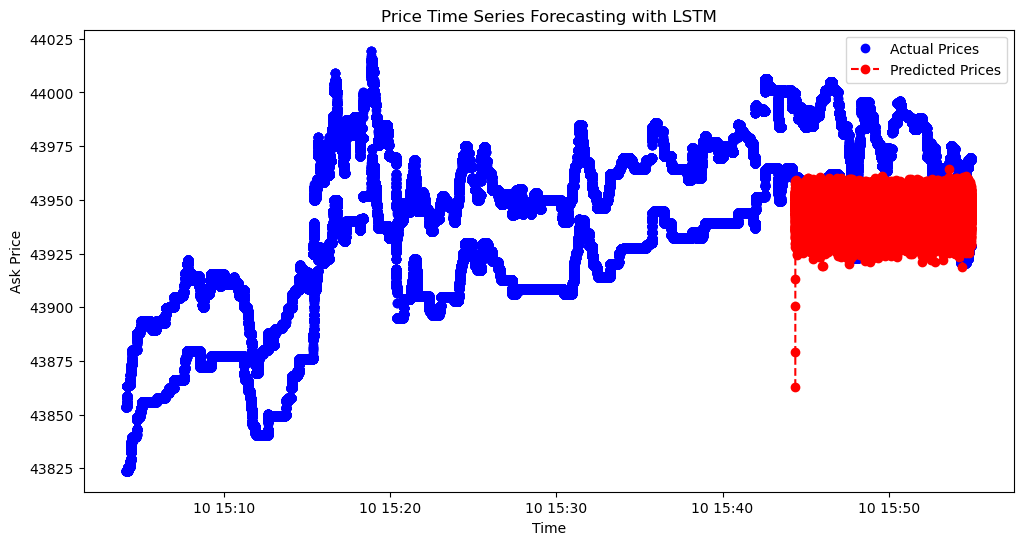

In [88]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# Feature selection
features = ['ap1', 'av1', 'bp1', 'bv1']

# Extract features and target
X = datas[features].values
y = datas['ap1'].values.reshape(-1, 1)
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Remove unnecessary dimensions
        return out    


# Initialize the model
input_size = len(features)
hidden_size = 50
output_size = 1
model = LSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

test_outputs_np = scaler_y.inverse_transform(test_outputs.numpy())
y_test_np = scaler_y.inverse_transform(y_test.numpy())
#test_outputs_np = scaler_y.inverse_transform(test_outputs.numpy().reshape(-1, len(features))).reshape(-1, len(features))
#y_test_np = scaler_y.inverse_transform(y_test.numpy().reshape(-1, len(features))).reshape(-1, len(features))

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_np, test_outputs_np)
print(f'Test Loss: {test_loss.item():.4f}, Mean Squared Error: {mse:.4f}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot_date(datas['ts'][0:], datas['ap1'][0:], label='Actual Prices', color='blue')
plt.plot_date(datas['ts'][train_size:],test_outputs_np[0:], label='Predicted Prices', linestyle='dashed', color='red')
plt.title('Price Time Series Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('Ask Price')
plt.legend()
plt.show()

